## Imports

In [2]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from result_inspection.toy_maze import *
from train_vqvae import sample_dataset

In [3]:
import ipywidgets as widgets
from IPython.display import display
from IPython.core.display import HTML

## Map: UPSIDE, Sampling: Oracle, SR: Yes

{
  "maze_type": "upside",
  "sampler": "oracle",
  "num_samples": 4096,
  "batch_size": 256,
  "learning_rate": 0.0002,
  "vae_args": {
    "codebook_size": 10,
    "code_size": 16,
    "beta": 1.5,
    "normalize_inputs": true,
    "hidden_size": 128,
    "num_layers": 3
  }
}
VQ-VAE was trained with samples from an oracle


/tmp/ipykernel_36539/166605167.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for emb_idx in tqdm_notebook(range(vae.codebook_size)):


  0%|          | 0/10 [00:00<?, ?it/s]

[4.5538473 3.1957517]
[7.6871347 8.330948 ]
[1.029288  1.5134451]
[8.393539  1.2408032]
[5.1544385 6.036527 ]
[1.2944756 5.0944686]
[3.9199593 8.313367 ]
[0.8830035 8.174008 ]
[8.086148  4.8632483]
[4.8244653 0.5789232]


/tmp/ipykernel_36539/166605167.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for code_number in tqdm_notebook(range(vae.codebook_size)):


  0%|          | 0/10 [00:00<?, ?it/s]

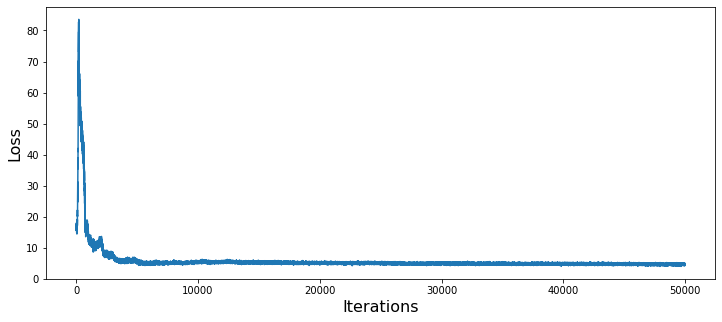

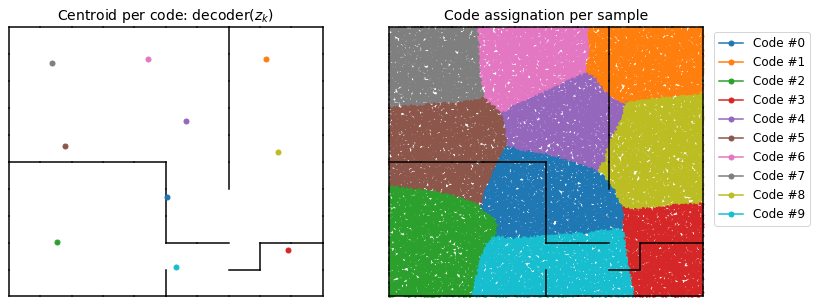

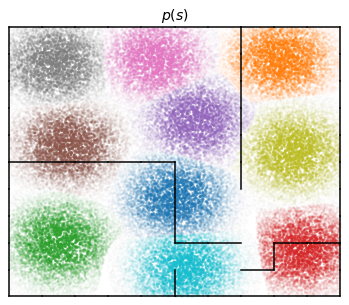

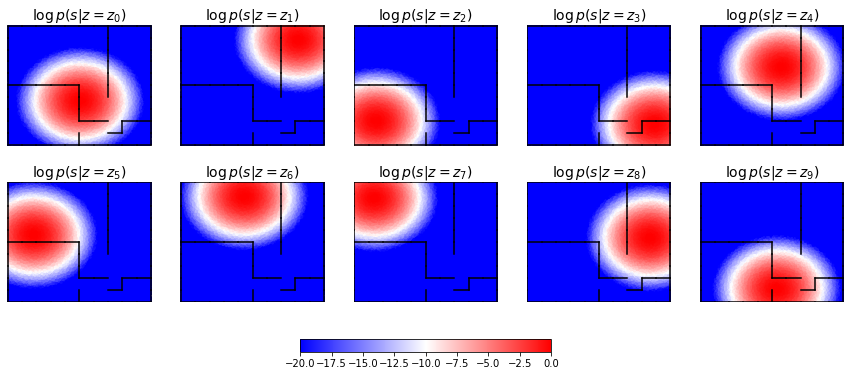

In [8]:
exp_name = "square_upside/vqvae_oracle_upside"
num_samples = 50000

vae, config, loss = load_vqvae(exp_name, verbose=True)

if config['sampler'] == 'smm':
    visualize_smm_samples(config['smm_exp_name'], epoch=config['smm_epoch'], figsize=(5,5), title="SMM samples")
else:
    print("VQ-VAE was trained with samples from an oracle")

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 5))
ax.plot(loss)
ax.set_xlabel('Iterations', fontsize=16)
_ = ax.set_ylabel('Loss', fontsize=16)

env, dataset = sample_dataset(config['maze_type'], num_samples=num_samples)

fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12.5, 5))

ax = axarr[0]
env.maze.plot(ax)
color_mapping = []
vae.to('cuda')
for emb_idx in tqdm_notebook(range(vae.codebook_size)):
    s = vae.get_centroids(dict(skill=torch.tensor(emb_idx)))[0].cpu().detach().numpy()
    print(s)
    m = ax.plot(s[0], s[1], marker='o', markersize=5, label='Code #{}'.format(emb_idx))
    color_mapping.append(m[0].get_color())
color_mapping_rgb = [list(int(h.lstrip('#')[i:i+2], 16)/255. for i in (0, 2, 4)) for h in color_mapping]
legend = ax.legend(loc='upper right', bbox_to_anchor=(2.55, 1), fontsize=12, ncol=1)
config_subplot(ax, maze_type=config['maze_type'], title="Centroid per code: $\mathrm{decoder}(z_k)$")

ax = axarr[1]
env.maze.plot(ax)
dataset = dataset.to('cuda')
z_q_x = vae.vq.quantize(vae.encoder(dataset)).cpu().detach().numpy()
dataset = dataset.to('cpu')
plt.scatter(dataset[:, 0], dataset[:, 1], c=[color_mapping[z] for z in z_q_x], s=3, marker='o')
config_subplot(ax, maze_type=config['maze_type'], title="Code assignation per sample")

prob_scale = 0.5  # alpha = prob_scale * prob; tune this depending on the number of samples used (use a smaller scale when using many samples)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))
env.maze.plot(ax)
dataset = dataset.to('cuda')
logprobs = vae.compute_logprob(dict(next_state=dataset)).cpu().detach().numpy()
rgba_colors = [color_mapping_rgb[z] + [prob_scale * prob] for z, prob in zip(z_q_x, np.exp(logprobs))]
dataset = dataset.to('cpu')
ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=np.array(rgba_colors))
config_subplot(ax, maze_type=config['maze_type'], title="$p(s)$")

ncols = 5
vmin, vmax = -20, 0  # range of values to visualize

nrows = math.ceil(vae.codebook_size / ncols)
fig, axarr = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3.4 * nrows))

for code_number in tqdm_notebook(range(vae.codebook_size)):
    ax = axarr.flatten()[code_number]
    env.maze.plot(ax)
    z = torch.full((len(dataset),), code_number, dtype=torch.long).to('cuda')
    dataset = dataset.to('cuda')
    logprobs = vae.compute_logprob_under_latent(dict(next_state=dataset, skill=z)).cpu().detach().numpy()
    dataset = dataset.to('cpu')
    sc = ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=logprobs, vmin=vmin, vmax=vmax, cmap='bwr')
    config_subplot(ax, maze_type=config['maze_type'], title="$\logp(s|z=z_{%d})$" % code_number)
    
for idx in range(code_number + 1, len(axarr.flatten())):
    axarr.flatten()[idx].axis('off')
    
plt.subplots_adjust(hspace=0.3)
cbar = fig.colorbar(sc, ax=axarr.ravel().tolist(), shrink=0.3, orientation="horizontal", pad=0.1)

## Map: UPSIDE, Sampling: SMM, SR: Yes

{
  "sampler": "smm",
  "smm_exp_name": "square_maze/smm_upside",
  "smm_epoch": 50,
  "batch_size": 256,
  "learning_rate": 0.0002,
  "vae_args": {
    "codebook_size": 10,
    "code_size": 16,
    "beta": 1.5,
    "normalize_inputs": true,
    "hidden_size": 128,
    "num_layers": 3
  },
  "maze_type": "upside"
}


  0%|          | 0/50 [00:00<?, ?it/s]



Loaded ReplayBuffer
  Path: /home/nas2_userI/byungkunlee/research/edl_origin/result_inspection/../logs/square_maze/smm_upside/0050_replay_buffer
  Size: 50000




/tmp/ipykernel_36539/404322168.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for emb_idx in tqdm_notebook(range(vae.codebook_size)):


  0%|          | 0/10 [00:00<?, ?it/s]

[0.62864286 1.3621409 ]
[0.48557436 0.27363497]
[-0.28864792  3.1294177 ]
[-0.15913185 -0.09580642]
[1.5049486 0.2535311]
[-0.28956565  0.8832161 ]
[ 0.875559   -0.13978952]
[0.16680983 1.415256  ]
[-0.39327118  2.0994515 ]
[-0.17833194  4.124495  ]


/tmp/ipykernel_36539/404322168.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for code_number in tqdm_notebook(range(vae.codebook_size)):


  0%|          | 0/10 [00:00<?, ?it/s]

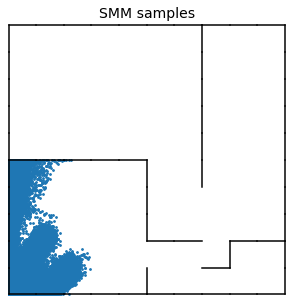

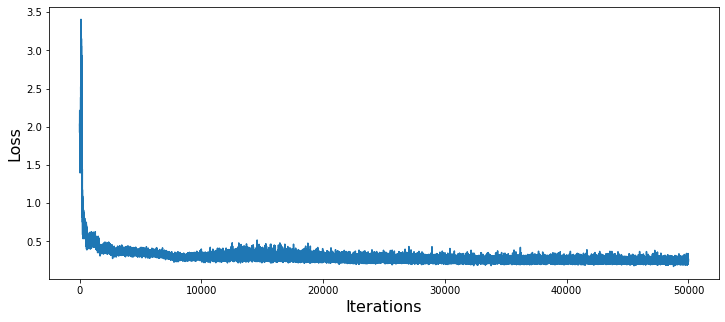

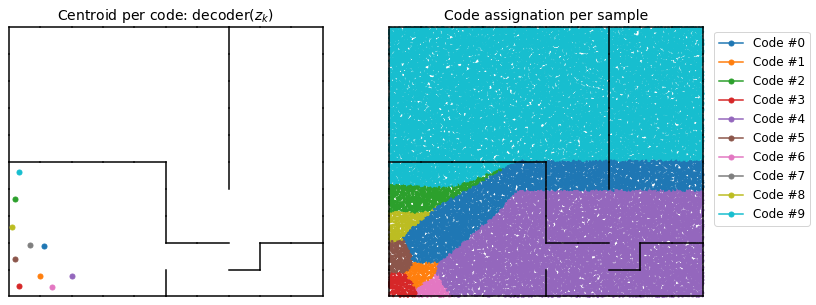

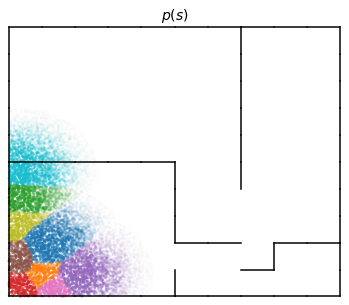

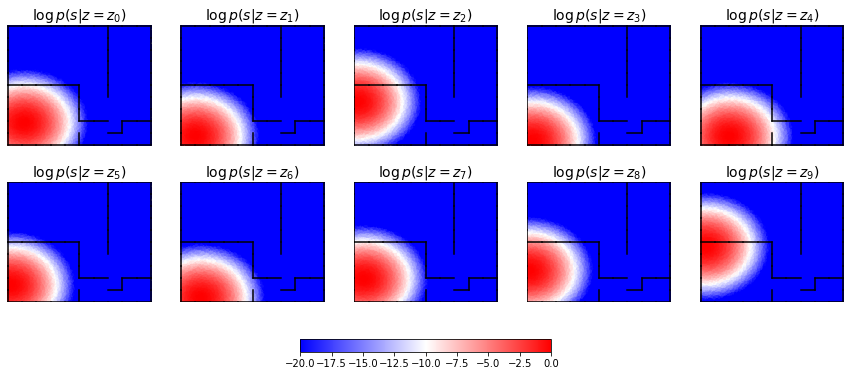

In [9]:
exp_name = "square_upside/vqvae_smm_upside"
num_samples = 50000

vae, config, loss = load_vqvae(exp_name, verbose=True)

if config['sampler'] == 'smm':
    visualize_smm_samples(config['smm_exp_name'], epoch=config['smm_epoch'], figsize=(5,5), title="SMM samples")
else:
    print("VQ-VAE was trained with samples from an oracle")

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 5))
ax.plot(loss)
ax.set_xlabel('Iterations', fontsize=16)
_ = ax.set_ylabel('Loss', fontsize=16)

env, dataset = sample_dataset(config['maze_type'], num_samples=num_samples)

fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12.5, 5))

ax = axarr[0]
env.maze.plot(ax)
color_mapping = []
vae.to('cuda')
for emb_idx in tqdm_notebook(range(vae.codebook_size)):
    s = vae.get_centroids(dict(skill=torch.tensor(emb_idx)))[0].cpu().detach().numpy()
    print(s)
    m = ax.plot(s[0], s[1], marker='o', markersize=5, label='Code #{}'.format(emb_idx))
    color_mapping.append(m[0].get_color())
color_mapping_rgb = [list(int(h.lstrip('#')[i:i+2], 16)/255. for i in (0, 2, 4)) for h in color_mapping]
legend = ax.legend(loc='upper right', bbox_to_anchor=(2.55, 1), fontsize=12, ncol=1)
config_subplot(ax, maze_type=config['maze_type'], title="Centroid per code: $\mathrm{decoder}(z_k)$")

ax = axarr[1]
env.maze.plot(ax)
dataset = dataset.to('cuda')
z_q_x = vae.vq.quantize(vae.encoder(dataset)).cpu().detach().numpy()
dataset = dataset.to('cpu')
plt.scatter(dataset[:, 0], dataset[:, 1], c=[color_mapping[z] for z in z_q_x], s=3, marker='o')
config_subplot(ax, maze_type=config['maze_type'], title="Code assignation per sample")

prob_scale = 0.5  # alpha = prob_scale * prob; tune this depending on the number of samples used (use a smaller scale when using many samples)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))
env.maze.plot(ax)
dataset = dataset.to('cuda')
logprobs = vae.compute_logprob(dict(next_state=dataset)).cpu().detach().numpy()
rgba_colors = [color_mapping_rgb[z] + [prob_scale * prob] for z, prob in zip(z_q_x, np.exp(logprobs))]
dataset = dataset.to('cpu')
ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=np.array(rgba_colors))
config_subplot(ax, maze_type=config['maze_type'], title="$p(s)$")

ncols = 5
vmin, vmax = -20, 0  # range of values to visualize

nrows = math.ceil(vae.codebook_size / ncols)
fig, axarr = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3.4 * nrows))

for code_number in tqdm_notebook(range(vae.codebook_size)):
    ax = axarr.flatten()[code_number]
    env.maze.plot(ax)
    z = torch.full((len(dataset),), code_number, dtype=torch.long).to('cuda')
    dataset = dataset.to('cuda')
    logprobs = vae.compute_logprob_under_latent(dict(next_state=dataset, skill=z)).cpu().detach().numpy()
    dataset = dataset.to('cpu')
    sc = ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=logprobs, vmin=vmin, vmax=vmax, cmap='bwr')
    config_subplot(ax, maze_type=config['maze_type'], title="$\logp(s|z=z_{%d})$" % code_number)
    
for idx in range(code_number + 1, len(axarr.flatten())):
    axarr.flatten()[idx].axis('off')
    
plt.subplots_adjust(hspace=0.3)
cbar = fig.colorbar(sc, ax=axarr.ravel().tolist(), shrink=0.3, orientation="horizontal", pad=0.1)

## Map: Bottleneck, Sampling: Oracle, SR: Yes

{
  "maze_type": "square_bottleneck",
  "sampler": "oracle",
  "num_samples": 4096,
  "batch_size": 256,
  "learning_rate": 0.0002,
  "vae_args": {
    "codebook_size": 10,
    "code_size": 16,
    "beta": 1.5,
    "normalize_inputs": true,
    "hidden_size": 128,
    "num_layers": 3
  }
}
VQ-VAE was trained with samples from an oracle


/tmp/ipykernel_4828/2298053163.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for emb_idx in tqdm_notebook(range(vae.codebook_size)):


  0%|          | 0/10 [00:00<?, ?it/s]

[0.51521873 8.602001  ]
[8.019547 7.802779]
[3.650352 8.360094]
[0.6350088 3.2638311]
[7.54908    0.92085767]
[0.73321795 0.7655096 ]
[0.44962072 6.116595  ]
[3.6240098 1.2305942]
[8.260348  3.8590539]
[4.597026  4.9995975]


/tmp/ipykernel_4828/2298053163.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for code_number in tqdm_notebook(range(vae.codebook_size)):


  0%|          | 0/10 [00:00<?, ?it/s]

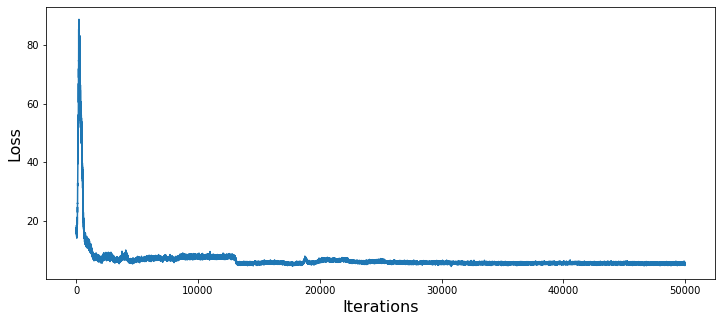

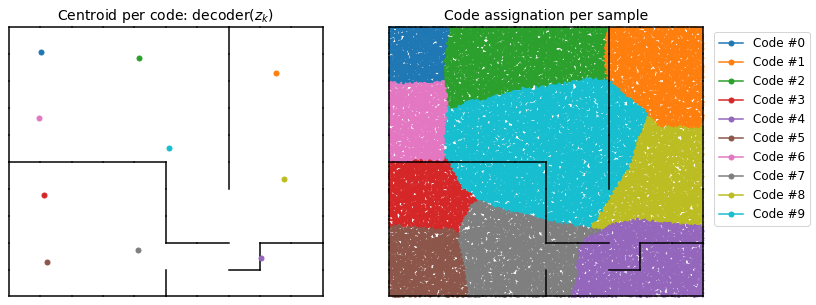

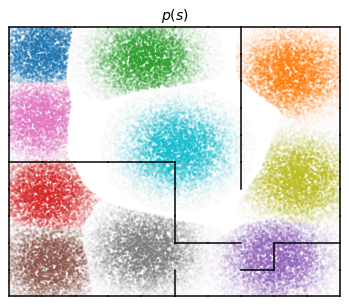

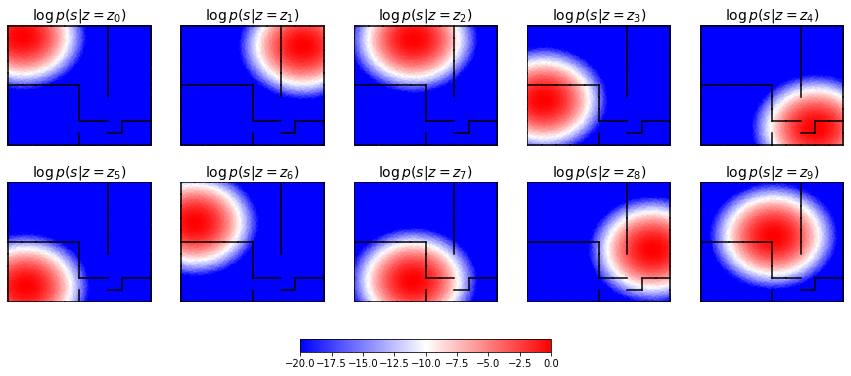

In [5]:
exp_name = "square_bottleneck/vqvae_oracle_bottleneck"
num_samples = 50000

vae, config, loss = load_vqvae(exp_name, verbose=True)

if config['sampler'] == 'smm':
    visualize_smm_samples(config['smm_exp_name'], epoch=config['smm_epoch'], figsize=(5,5), title="SMM samples")
else:
    print("VQ-VAE was trained with samples from an oracle")

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 5))
ax.plot(loss)
ax.set_xlabel('Iterations', fontsize=16)
_ = ax.set_ylabel('Loss', fontsize=16)

env, dataset = sample_dataset(config['maze_type'], num_samples=num_samples)

fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12.5, 5))

ax = axarr[0]
env.maze.plot(ax)
color_mapping = []
vae.to('cuda')
for emb_idx in tqdm_notebook(range(vae.codebook_size)):
    s = vae.get_centroids(dict(skill=torch.tensor(emb_idx)))[0].cpu().detach().numpy()
    print(s)
    m = ax.plot(s[0], s[1], marker='o', markersize=5, label='Code #{}'.format(emb_idx))
    color_mapping.append(m[0].get_color())
color_mapping_rgb = [list(int(h.lstrip('#')[i:i+2], 16)/255. for i in (0, 2, 4)) for h in color_mapping]
legend = ax.legend(loc='upper right', bbox_to_anchor=(2.55, 1), fontsize=12, ncol=1)
config_subplot(ax, maze_type=config['maze_type'], title="Centroid per code: $\mathrm{decoder}(z_k)$")

ax = axarr[1]
env.maze.plot(ax)
dataset = dataset.to('cuda')
z_q_x = vae.vq.quantize(vae.encoder(dataset)).cpu().detach().numpy()
dataset = dataset.to('cpu')
plt.scatter(dataset[:, 0], dataset[:, 1], c=[color_mapping[z] for z in z_q_x], s=3, marker='o')
config_subplot(ax, maze_type=config['maze_type'], title="Code assignation per sample")

prob_scale = 0.5  # alpha = prob_scale * prob; tune this depending on the number of samples used (use a smaller scale when using many samples)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))
env.maze.plot(ax)
dataset = dataset.to('cuda')
logprobs = vae.compute_logprob(dict(next_state=dataset)).cpu().detach().numpy()
rgba_colors = [color_mapping_rgb[z] + [prob_scale * prob] for z, prob in zip(z_q_x, np.exp(logprobs))]
dataset = dataset.to('cpu')
ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=np.array(rgba_colors))
config_subplot(ax, maze_type=config['maze_type'], title="$p(s)$")

ncols = 5
vmin, vmax = -20, 0  # range of values to visualize

nrows = math.ceil(vae.codebook_size / ncols)
fig, axarr = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3.4 * nrows))

for code_number in tqdm_notebook(range(vae.codebook_size)):
    ax = axarr.flatten()[code_number]
    env.maze.plot(ax)
    z = torch.full((len(dataset),), code_number, dtype=torch.long).to('cuda')
    dataset = dataset.to('cuda')
    logprobs = vae.compute_logprob_under_latent(dict(next_state=dataset, skill=z)).cpu().detach().numpy()
    dataset = dataset.to('cpu')
    sc = ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=logprobs, vmin=vmin, vmax=vmax, cmap='bwr')
    config_subplot(ax, maze_type=config['maze_type'], title="$\logp(s|z=z_{%d})$" % code_number)
    
for idx in range(code_number + 1, len(axarr.flatten())):
    axarr.flatten()[idx].axis('off')
    
plt.subplots_adjust(hspace=0.3)
cbar = fig.colorbar(sc, ax=axarr.ravel().tolist(), shrink=0.3, orientation="horizontal", pad=0.1)

## Map: Bottleneck, Sampling: SMM, SR: Yes

{
  "sampler": "smm",
  "smm_exp_name": "square_maze/smm_bottleneck",
  "smm_epoch": 50,
  "batch_size": 256,
  "learning_rate": 0.0002,
  "vae_args": {
    "codebook_size": 10,
    "code_size": 16,
    "beta": 1.5,
    "normalize_inputs": true,
    "hidden_size": 128,
    "num_layers": 3
  },
  "maze_type": "square_bottleneck"
}


  0%|          | 0/50 [00:00<?, ?it/s]



Loaded ReplayBuffer
  Path: /home/nas2_userI/byungkunlee/research/edl_origin/result_inspection/../logs/square_maze/smm_bottleneck/0050_replay_buffer
  Size: 50000




/tmp/ipykernel_36539/2440213598.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for emb_idx in tqdm_notebook(range(vae.codebook_size)):


  0%|          | 0/10 [00:00<?, ?it/s]

[9.403169 9.368398]
[9.089243  4.1525035]
[2.638636 3.544694]
[-0.10630894  4.073099  ]
[-0.20362186  2.1158676 ]
[8.220916   0.25748086]
[3.8370252 4.1628647]
[0.97336435 4.1216397 ]
[1.3639439  0.03842688]
[5.030883   0.33337712]


/tmp/ipykernel_36539/2440213598.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for code_number in tqdm_notebook(range(vae.codebook_size)):


  0%|          | 0/10 [00:00<?, ?it/s]

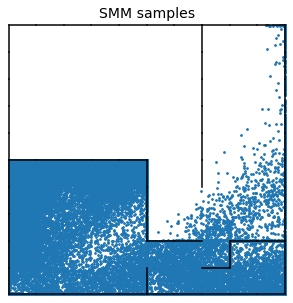

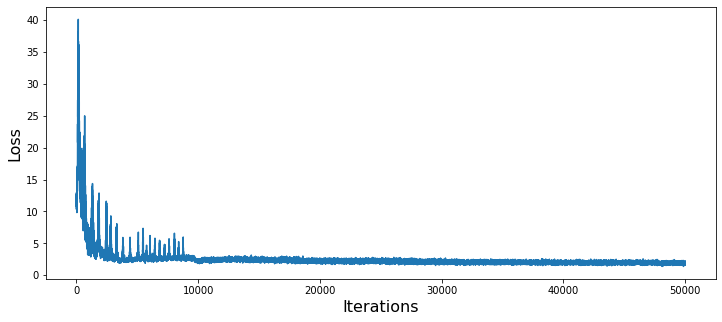

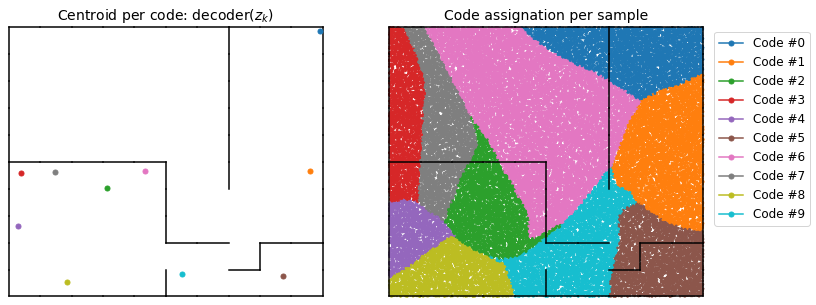

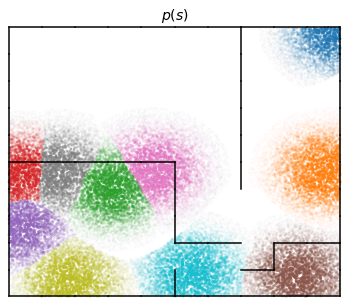

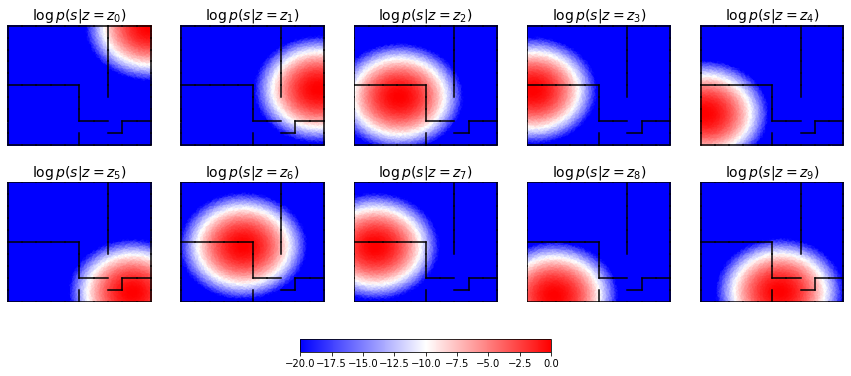

In [12]:
exp_name = "square_bottleneck/vqvae_smm_bottleneck"
num_samples = 50000

vae, config, loss = load_vqvae(exp_name, verbose=True)

if config['sampler'] == 'smm':
    visualize_smm_samples(config['smm_exp_name'], epoch=config['smm_epoch'], figsize=(5,5), title="SMM samples")
else:
    print("VQ-VAE was trained with samples from an oracle")

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 5))
ax.plot(loss)
ax.set_xlabel('Iterations', fontsize=16)
_ = ax.set_ylabel('Loss', fontsize=16)

env, dataset = sample_dataset(config['maze_type'], num_samples=num_samples)

fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12.5, 5))

ax = axarr[0]
env.maze.plot(ax)
color_mapping = []
vae.to('cuda')
for emb_idx in tqdm_notebook(range(vae.codebook_size)):
    s = vae.get_centroids(dict(skill=torch.tensor(emb_idx)))[0].cpu().detach().numpy()
    print(s)
    m = ax.plot(s[0], s[1], marker='o', markersize=5, label='Code #{}'.format(emb_idx))
    color_mapping.append(m[0].get_color())
color_mapping_rgb = [list(int(h.lstrip('#')[i:i+2], 16)/255. for i in (0, 2, 4)) for h in color_mapping]
legend = ax.legend(loc='upper right', bbox_to_anchor=(2.55, 1), fontsize=12, ncol=1)
config_subplot(ax, maze_type=config['maze_type'], title="Centroid per code: $\mathrm{decoder}(z_k)$")

ax = axarr[1]
env.maze.plot(ax)
dataset = dataset.to('cuda')
z_q_x = vae.vq.quantize(vae.encoder(dataset)).cpu().detach().numpy()
dataset = dataset.to('cpu')
plt.scatter(dataset[:, 0], dataset[:, 1], c=[color_mapping[z] for z in z_q_x], s=3, marker='o')
config_subplot(ax, maze_type=config['maze_type'], title="Code assignation per sample")

prob_scale = 0.5  # alpha = prob_scale * prob; tune this depending on the number of samples used (use a smaller scale when using many samples)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))
env.maze.plot(ax)
dataset = dataset.to('cuda')
logprobs = vae.compute_logprob(dict(next_state=dataset)).cpu().detach().numpy()
rgba_colors = [color_mapping_rgb[z] + [prob_scale * prob] for z, prob in zip(z_q_x, np.exp(logprobs))]
dataset = dataset.to('cpu')
ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=np.array(rgba_colors))
config_subplot(ax, maze_type=config['maze_type'], title="$p(s)$")

ncols = 5
vmin, vmax = -20, 0  # range of values to visualize

nrows = math.ceil(vae.codebook_size / ncols)
fig, axarr = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3.4 * nrows))

for code_number in tqdm_notebook(range(vae.codebook_size)):
    ax = axarr.flatten()[code_number]
    env.maze.plot(ax)
    z = torch.full((len(dataset),), code_number, dtype=torch.long).to('cuda')
    dataset = dataset.to('cuda')
    logprobs = vae.compute_logprob_under_latent(dict(next_state=dataset, skill=z)).cpu().detach().numpy()
    dataset = dataset.to('cpu')
    sc = ax.scatter(dataset[:, 0], dataset[:, 1], s=3, marker='o', c=logprobs, vmin=vmin, vmax=vmax, cmap='bwr')
    config_subplot(ax, maze_type=config['maze_type'], title="$\logp(s|z=z_{%d})$" % code_number)
    
for idx in range(code_number + 1, len(axarr.flatten())):
    axarr.flatten()[idx].axis('off')
    
plt.subplots_adjust(hspace=0.3)
cbar = fig.colorbar(sc, ax=axarr.ravel().tolist(), shrink=0.3, orientation="horizontal", pad=0.1)